# Diffusion model Training and Image Generation

This notebook demonstrates the training of the Diffusion model and generating new images using the trained model.



In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import gc
import cv2
import math
import base64
import random
from tqdm import tqdm
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.optim.swa_utils import AveragedModel, update_bn
import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from IPython.display import display, HTML, clear_output

Let's create dataloaders and preprocess it:

In [ ]:
from dataset import create_dataset
dataloader = create_dataset()

Let's import Unet model:

In [ ]:
from diffusion_model import UNet
from utils import *
from noise import SimpleDiffusion
sd = SimpleDiffusion(
    num_diffusion_timesteps=1000
)
loader = dataloader
loader

In [ ]:
from train import train_one_epoch

# Algorithm 2: Sampling

@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64),
                      num_images=5, nrow=8, device="cpu", generate_video=False, **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    if kwargs.get("generate_video", False):
        outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)),
                          total=timesteps-1, dynamic_ncols=False,
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts)

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        if generate_video:
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)

    if generate_video: # Generate and save video of the entire reverse process.
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.

    else: # Display and save the image at the final timestep of the reverse process.
        x = inverse_transform(x).type(torch.uint8)
        grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)

        display_image(grid.permute(1, 2, 0))
    return grid

In [ ]:
from torch.cuda import amp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(

).to(device)

dataloader = DeviceDataLoader(dataloader, device='cpu')

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = 1000,
    img_shape               = (3, 64, 64),
).to(device)

scaler = torch.cuda.amp.GradScaler()


### Training:

In [ ]:
for epoch in range(1, 35):
    torch.cuda.empty_cache()
    gc.collect()

    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch, total_epochs = 20)


    # clear_output()
    checkpoint_dict = {
        "opt": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
        "model": model.state_dict()
    }
    torch.save(checkpoint_dict, os.path.join("model.ckpt"))
    del checkpoint_dict

### Loading trained model on 35 epochs:

In [ ]:
import gdown

file_id = "1fQoEAaiVJeBYbmZorFwp6sJOSeIHx6ze"
url = f"https://drive.google.com/uc?id={file_id}"

output = "model.pth"
gdown.download(url, output, quiet=False)

checkpoint_path = "/content/model.pth"
checkpoint = torch.load(checkpoint_path)
model = UNet()
model.load_state_dict(checkpoint["model"])
model = model.cuda()


In [ ]:
from generate import generate
generate(model, sd,  num_images=32, timesteps=1000, nrow=8, format='png', device=device)

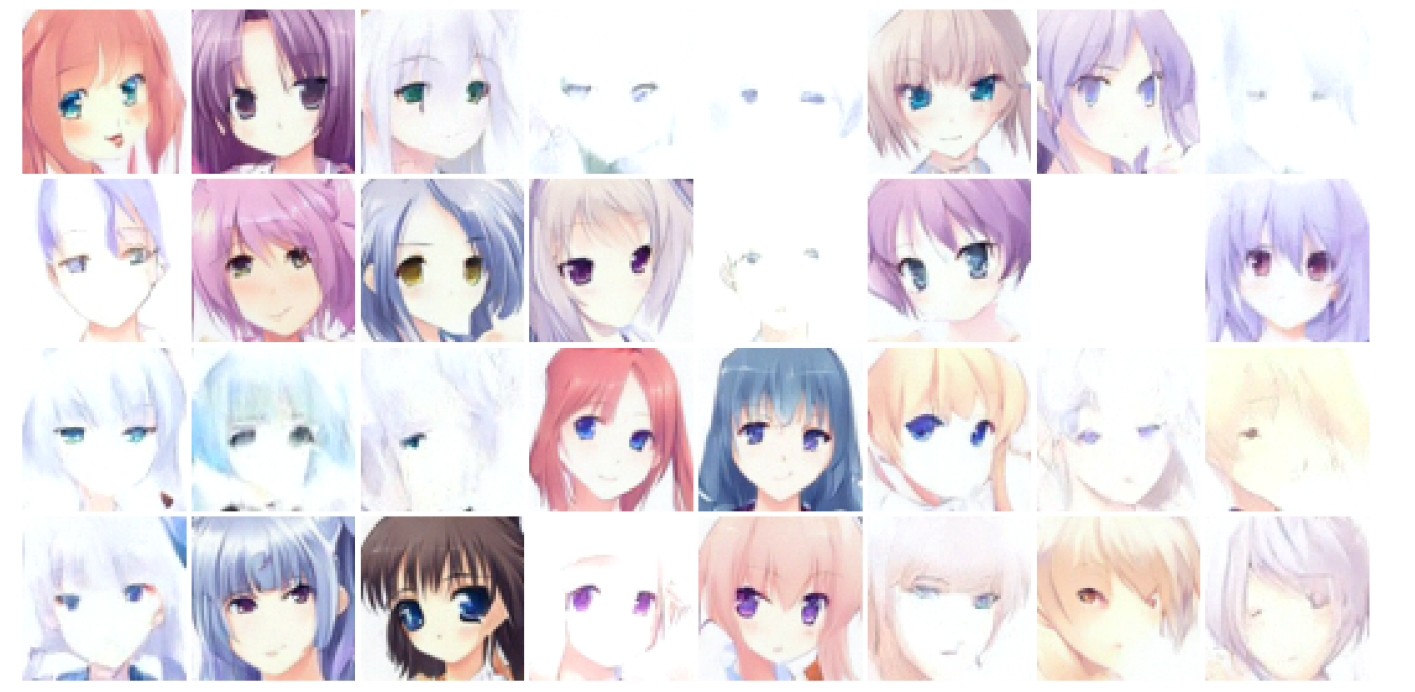